In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("pastel")

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [2]:
df = pd.read_csv('indian_liver_patient.csv')

df.Gender = df.Gender.replace({'Female': 0, 'Male': 1})
df.rename(columns = {'Dataset': 'isPatient'}, inplace = True)
df.isPatient.replace({2:0}, inplace = True)
# df.dropna(inplace = True)
df.head()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,isPatient
0,65,0,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,1,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,1,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,1,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,1,3.9,2.0,195,27,59,7.3,2.4,0.40,1


# Inspect the Data

In [3]:
df.isna().sum()

Age                           0
Gender                        0
Total_Bilirubin               0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    4
isPatient                     0
dtype: int64

> We have 4 missing values for one of our variables.  We will address this before we implement our Machine Learning Algorithm.

In [4]:
df.groupby('isPatient').mean(numeric_only = True)

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio
isPatient,,,,,,,,,,
0,41.239521,0.700599,1.142515,0.396407,219.754491,33.652695,40.688623,6.543114,3.344311,1.029576
1,46.153846,0.778846,4.164423,1.923558,319.007212,99.605769,137.699519,6.459135,3.060577,0.914179


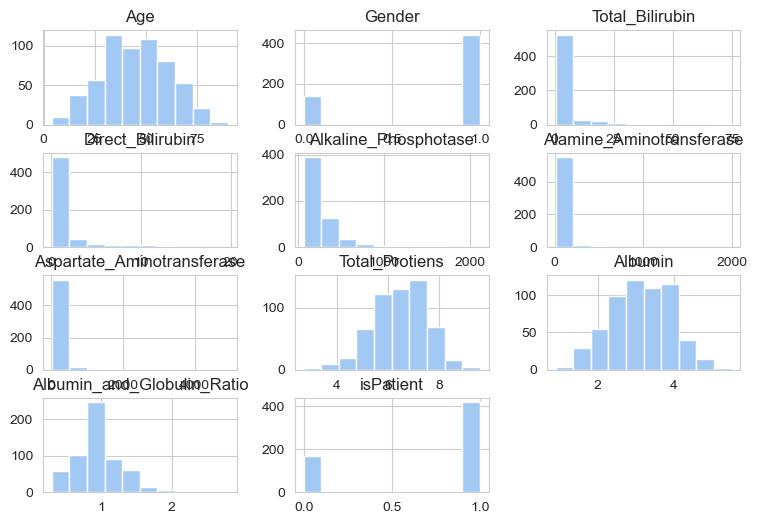

In [5]:
df.hist(bins = 10, figsize = (9,6))
plt.show()

# Split Data

<p>Let's split the data before we begin to explore it.  We don't want to find random patterns in the data that may bias our feature selection for our Machien Learning Algorithm.</p>

In [6]:
# doing a stratified shuffle split ensures that the amount of non-liver and liver patients have 
# the same ratio in our train and test sets

split = StratifiedShuffleSplit(n_splits = 1, train_size = .8, random_state = 42)

for train_index, test_index in split.split(df, df.isPatient):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]
    
print(df.isPatient.value_counts() / len(df))
print(strat_train_set.isPatient.value_counts() / len(strat_train_set))

1    0.713551
0    0.286449
Name: isPatient, dtype: float64
1    0.714592
0    0.285408
Name: isPatient, dtype: float64


In [7]:
strat_train_set.head()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,isPatient
21,51,1,2.9,1.3,482,22,34,7.0,2.4,0.50,1
68,66,1,0.7,0.2,239,27,26,6.3,3.7,1.40,1
321,30,0,0.8,0.2,198,30,58,5.2,2.8,1.10,1
317,35,1,0.7,0.2,198,42,30,6.8,3.4,1.00,1
110,24,0,0.7,0.2,188,11,10,5.5,2.3,0.71,0


# Explore Data

In [8]:
df = strat_train_set.copy()
group = df.groupby('isPatient').mean()
group

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio
isPatient,,,,,,,,,,
0,40.639098,0.684211,1.193985,0.428571,226.398496,34.939850,40.812030,6.562406,3.335338,1.017634
1,46.069069,0.780781,3.687988,1.750150,321.027027,102.405405,129.072072,6.452553,3.080480,0.924804


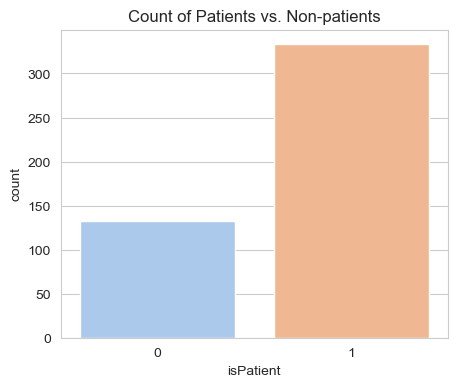

In [9]:
plt.figure(figsize = (5,4))
sns.countplot(data = df, x = 'isPatient')
plt.title("Count of Patients vs. Non-patients")
plt.show()

In [10]:
df.isPatient.value_counts()

1    333
0    133
Name: isPatient, dtype: int64

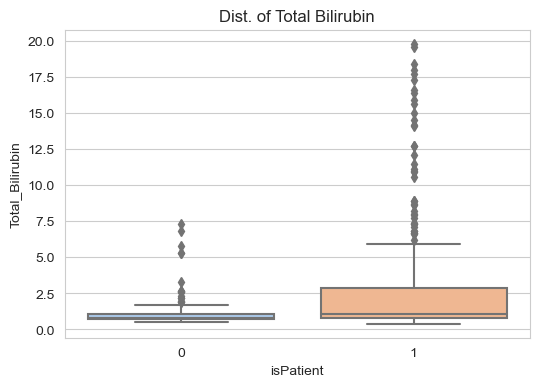

In [11]:
plt.figure(figsize = (6,4))
sns.boxplot(data = df[df.Total_Bilirubin < 20], x = 'isPatient', y = 'Total_Bilirubin')
plt.title("Dist. of Total Bilirubin")
plt.show()

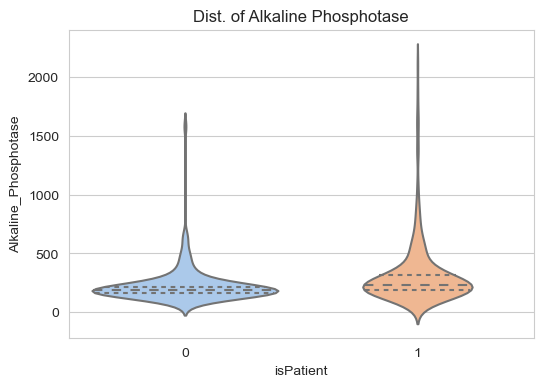

In [12]:
plt.figure(figsize=(6,4))
sns.violinplot(data = df, x = 'isPatient', y = 'Alkaline_Phosphotase', inner = 'quartile')
plt.title("Dist. of Alkaline Phosphotase")
plt.show()

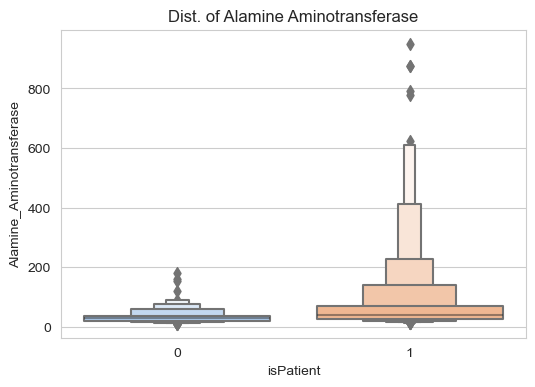

In [13]:
plt.figure(figsize=(6,4))
sns.boxenplot(data = df[df.Alamine_Aminotransferase < 1200], x = 'isPatient', y = 'Alamine_Aminotransferase')
plt.title("Dist. of Alamine Aminotransferase")
plt.show()

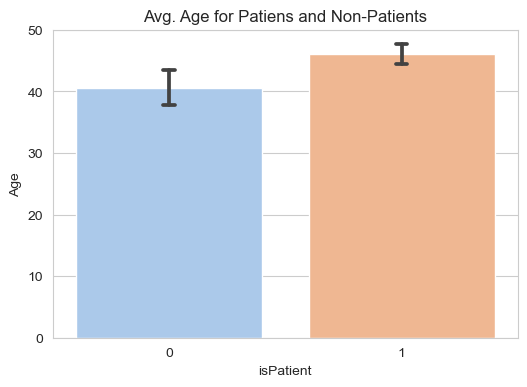

In [14]:
plt.figure(figsize=(6,4))
sns.barplot(data = df, x = 'isPatient', y = 'Age', capsize = .05)
plt.title("Avg. Age for Patiens and Non-Patients")
plt.show()

# Statistical Significance Testing

Let's perform some statistical significance testing on some of the variables that aren't obviously different for each group.
This will give us some insight on which variables we should add to our ML algorithm.
> Variables to perform Statistical Tests on: <br>
> 1. Age <br>
> 2. Gender <br>
> 3. Total Protiens <br>
> 4. Albumin <br>
> 5. Albumin and Globulin Ratio

In [15]:
def perm_fun(df, col, len_a):
    a = df.sample(n = len_a, replace = False)
    b = df[~df.index.isin(a.index)]
    
    return a[col].mean() - b[col].mean()

In [16]:
def generate_diffs_and_graph(col, len_a, df):
    # generated permuted differences
    actual_diff = group.loc[1][col] - group.loc[0][col]
    diffs = [perm_fun(df, col, len_a) for _ in range(1000)]
    
    # plot permuted differences and actual difference
    plt.figure(figsize = (5,4))
    sns.histplot(diffs)
    plt.axvline(x = actual_diff, color = 'red')
    plt.title(f"Perm Test (statistical significance) for {col}")
    plt.show()

    # calculate and print p-val for statistical significance test
    p_val = [np.abs(diff) > np.abs(actual_diff) for diff in diffs]
    p_val = np.array(p_val).mean()
    print("p-val:", p_val)
    
    return p_val

In [17]:
num_patients = df.isPatient.value_counts().loc[1]
significant_vars = []
print("Number of patients in training set:", num_patients)

Number of patients in training set: 333


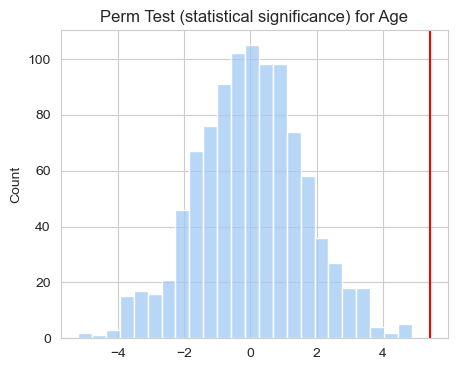

p-val: 0.0


In [18]:
age_pval = generate_diffs_and_graph('Age', num_patients, df)
if age_pval <= .05:
    significant_vars.append('Age')

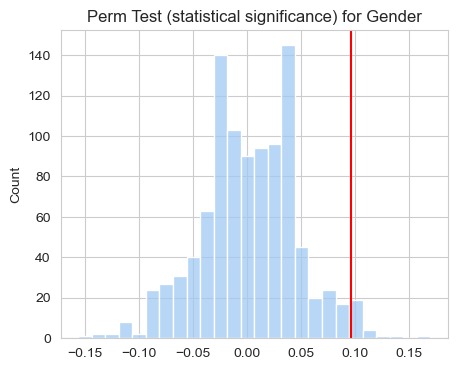

p-val: 0.028


In [19]:
age_pval = generate_diffs_and_graph('Gender', num_patients, df)
if age_pval <= .05:
    significant_vars.append('Gender')

In [20]:
df.head()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,isPatient
21,51,1,2.9,1.3,482,22,34,7.0,2.4,0.50,1
68,66,1,0.7,0.2,239,27,26,6.3,3.7,1.40,1
321,30,0,0.8,0.2,198,30,58,5.2,2.8,1.10,1
317,35,1,0.7,0.2,198,42,30,6.8,3.4,1.00,1
110,24,0,0.7,0.2,188,11,10,5.5,2.3,0.71,0


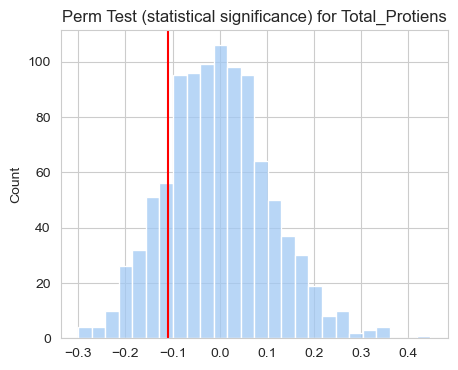

p-val: 0.312


In [21]:
age_pval = generate_diffs_and_graph('Total_Protiens', num_patients, df)
if age_pval <= .05:
    significant_vars.append('Total_Protiens')

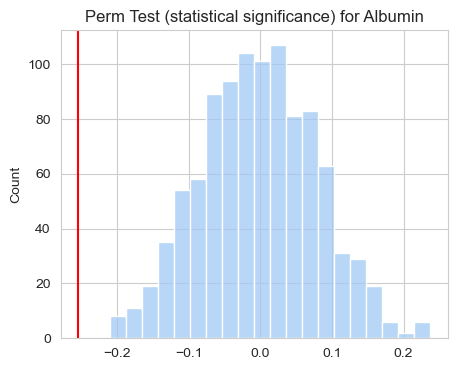

p-val: 0.0


In [22]:
age_pval = generate_diffs_and_graph('Albumin', num_patients, df)
if age_pval <= .05:
    significant_vars.append('Albumin')

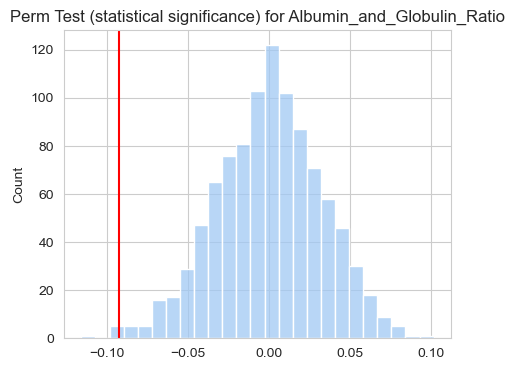

p-val: 0.006


In [23]:
age_pval = generate_diffs_and_graph('Albumin_and_Globulin_Ratio', num_patients, df)
if age_pval <= .05:
    significant_vars.append('Albumin_and_Globulin_Ratio')

In [24]:
# we will add the following variables to our algorithm
significant_vars.append('Total_Bilirubin')

significant_vars

['Age', 'Gender', 'Albumin', 'Albumin_and_Globulin_Ratio', 'Total_Bilirubin']

# Feature Selection

In [25]:
sig_features = np.array(significant_vars).copy()
all_features = np.append(sig_features, ['Total_Bilirubin', 'Direct_Bilirubin', 'Alkaline_Phosphotase', 
                                    'Alamine_Aminotransferase', 'Aspartate_Aminotransferase'])
all_features

array(['Age', 'Gender', 'Albumin', 'Albumin_and_Globulin_Ratio',
       'Total_Bilirubin', 'Total_Bilirubin', 'Direct_Bilirubin',
       'Alkaline_Phosphotase', 'Alamine_Aminotransferase',
       'Aspartate_Aminotransferase'], dtype='<U26')

### Clean Data before putting it into model

In [47]:
imputer = SimpleImputer(strategy = 'median')

imputer.fit(strat_train_set[all_features])

SimpleImputer(strategy='median')

In [48]:
# data was already split, no need to split again
X_train = imputer.transform(strat_train_set[all_features]) # fill in missing x values with median value
y_train = np.array(strat_train_set['isPatient']).reshape(-1,1)

In [49]:
norm_layer = tf.keras.layers.Normalization(axis = -1)
norm_layer.adapt(X_train) # learns mean and variance
X_train_norm = norm_layer(X_train)

In [50]:
X_train_norm

<tf.Tensor: shape=(466, 10), dtype=float32, numpy=
array([[ 0.40546107,  0.5723944 , -0.95533293, ...,  0.7441994 ,
        -0.31704962, -0.31261483],
       [ 1.3439279 ,  0.5723944 ,  0.6935009 , ..., -0.21781659,
        -0.29112577, -0.3484026 ],
       [-0.9083925 , -1.7470473 , -0.44799963, ..., -0.38013205,
        -0.2755715 , -0.20525157],
       ...,
       [ 1.9070079 ,  0.5723944 , -0.32116607, ...,  0.32059562,
         0.00959066, -0.16051689],
       [-0.3453124 ,  0.5723944 ,  0.18616726, ...,  0.0157593 ,
         0.09773169,  2.3535726 ],
       [ 0.65571886,  0.5723944 , -0.57483286, ..., -0.41180336,
        -0.3014953 , -0.33945563]], dtype=float32)>

# Tensorflow Model

In [67]:
tf.random.set_seed(42)

# define model
model = Sequential([
    Dense(units = 50, activation = 'relu', kernel_regularizer  = tf.keras.regularizers.l2(.001)),
    Dense(units = 25, activation = 'relu', kernel_regularizer  = tf.keras.regularizers.l2(.001)),
    Dense(units = 1, activation = 'linear', kernel_regularizer = tf.keras.regularizers.l2(.001))
])

In [68]:
# define loss function
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01)
)

In [69]:
# fit model
history = model.fit(X_train, y_train, epochs = 1000, verbose = 0, validation_split = 0.2)

# Looking for Overfit

In [70]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
995,0.464444,0.619547,995
996,0.465632,0.695605,996
997,0.418841,0.707632,997
998,0.419569,0.708314,998
999,0.410503,0.680659,999


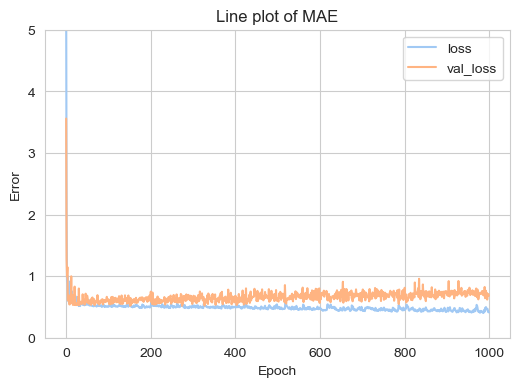

In [71]:
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, 5])

plt.title("Line plot of MAE")
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.grid(True)

In [78]:
X_test_norm = norm_layer(strat_test_set[all_features])

logit = model(X_test_norm)
predictions = tf.nn.sigmoid(logit) # apply sigmoid function to predictions

In [79]:
strat_test_set['nn_prob'] = predictions
strat_test_set['Prediction'] = (strat_test_set.nn_prob >= .5).replace({False: 0, True: 1})
strat_test_set

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,isPatient,nn_prediction,nn_prob,Prediction
70,19,0,0.7,0.2,186,166,397,5.5,3.0,1.20,1,0.556744,0.556744,1
61,58,1,1.0,0.5,158,37,43,7.2,3.6,1.00,1,0.650280,0.650280,1
252,65,1,1.1,0.3,258,48,40,7.0,3.9,1.20,0,0.712958,0.712958,1
136,46,0,4.7,2.2,310,62,90,6.4,2.5,0.60,1,0.340689,0.340689,0
396,74,1,1.0,0.3,175,30,32,6.4,3.4,1.10,1,0.725935,0.725935,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,60,1,2.4,1.0,1124,30,54,5.2,1.9,0.50,1,0.321718,0.321718,0
276,35,1,0.9,0.2,190,25,20,6.4,3.6,1.20,0,0.518461,0.518461,1
549,40,0,2.1,1.0,768,74,141,7.8,4.9,1.60,1,0.601924,0.601924,1
444,61,1,0.8,0.2,163,18,19,6.3,2.8,0.80,0,0.602891,0.602891,1


In [80]:
accuracy_score(strat_test_set.isPatient, strat_test_set.Prediction)

0.4358974358974359